
--- Generating Operating Curve for Scenario: Baseline ---
  Running simulation with 10 lots per type...
  Completed 12 lots. Avg WIP: 0.26, Avg Cycle Time: 23552.50
  Running simulation with 25 lots per type...
  Completed 27 lots. Avg WIP: 0.58, Avg Cycle Time: 23493.25
  Running simulation with 50 lots per type...
  Completed 57 lots. Avg WIP: 1.22, Avg Cycle Time: 23460.36
  Running simulation with 75 lots per type...
  Completed 81 lots. Avg WIP: 1.77, Avg Cycle Time: 23451.09
  Running simulation with 100 lots per type...
  Completed 102 lots. Avg WIP: 2.22, Avg Cycle Time: 23476.60
  Running simulation with 125 lots per type...
  Completed 134 lots. Avg WIP: 2.90, Avg Cycle Time: 23523.34
  Running simulation with 150 lots per type...
  Completed 161 lots. Avg WIP: 3.48, Avg Cycle Time: 23517.03
  Running simulation with 175 lots per type...
  Completed 193 lots. Avg WIP: 4.17, Avg Cycle Time: 23562.21
  Running simulation with 200 lots per type...
  Completed 217 lots. Avg WIP:

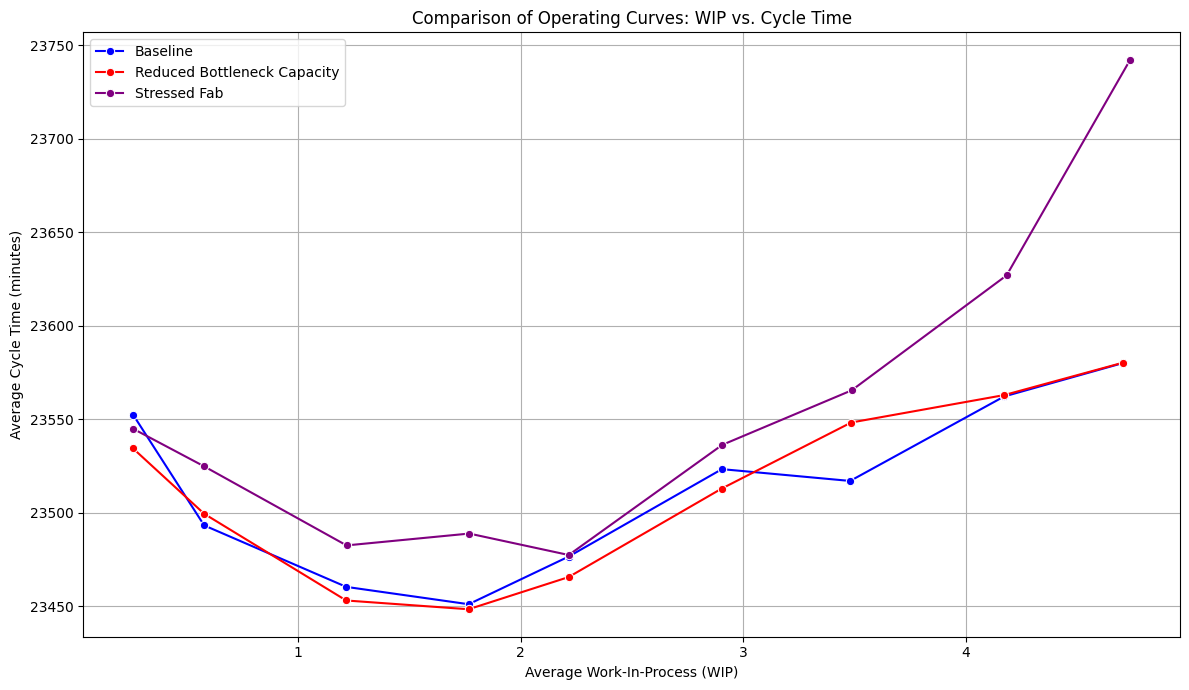


--- Bottleneck Analysis for Stressed Fab (Highest Load) ---
                 AvgQueueLength  AvgUtilization  Capacity
Delay_32               0.070000       22.409091         2
DE_FE_86               0.032727       24.909091         2
LithoMet_BE_18         0.005455        9.318182         2
DE_FE_71               0.004545       10.636364         2
LithoMet_FE_19         0.002727       10.181818         2
TF_BE_40               0.002727        9.500000         2
TF_BE_23               0.002727        8.136364         2
Litho_REG_FE_64        0.001818        8.227273         2
WE_FE_108              0.001818        8.045455         2
DE_BE_66               0.001818        5.000000         2

--- Generating Detailed Plots for Stressed Fab (Highest Load) ---


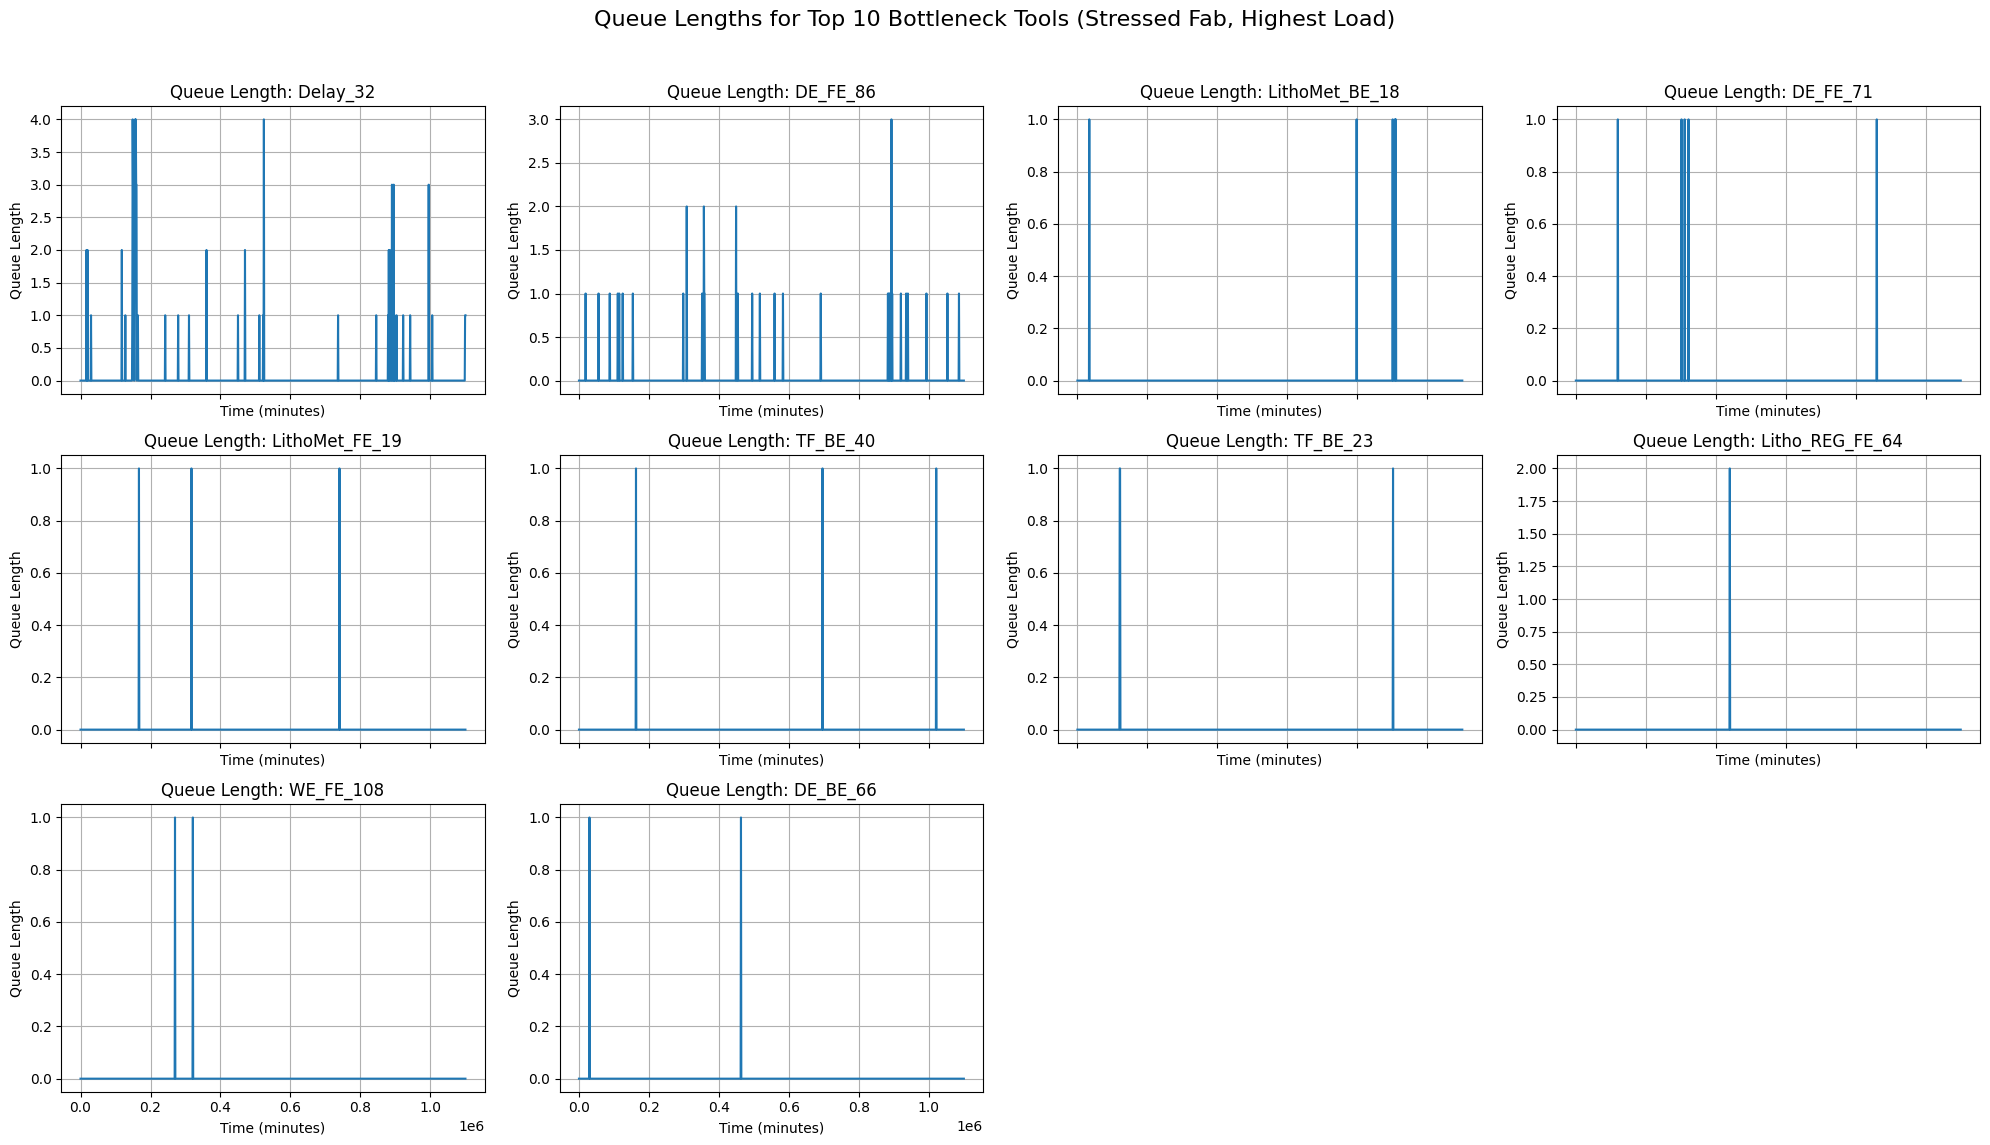

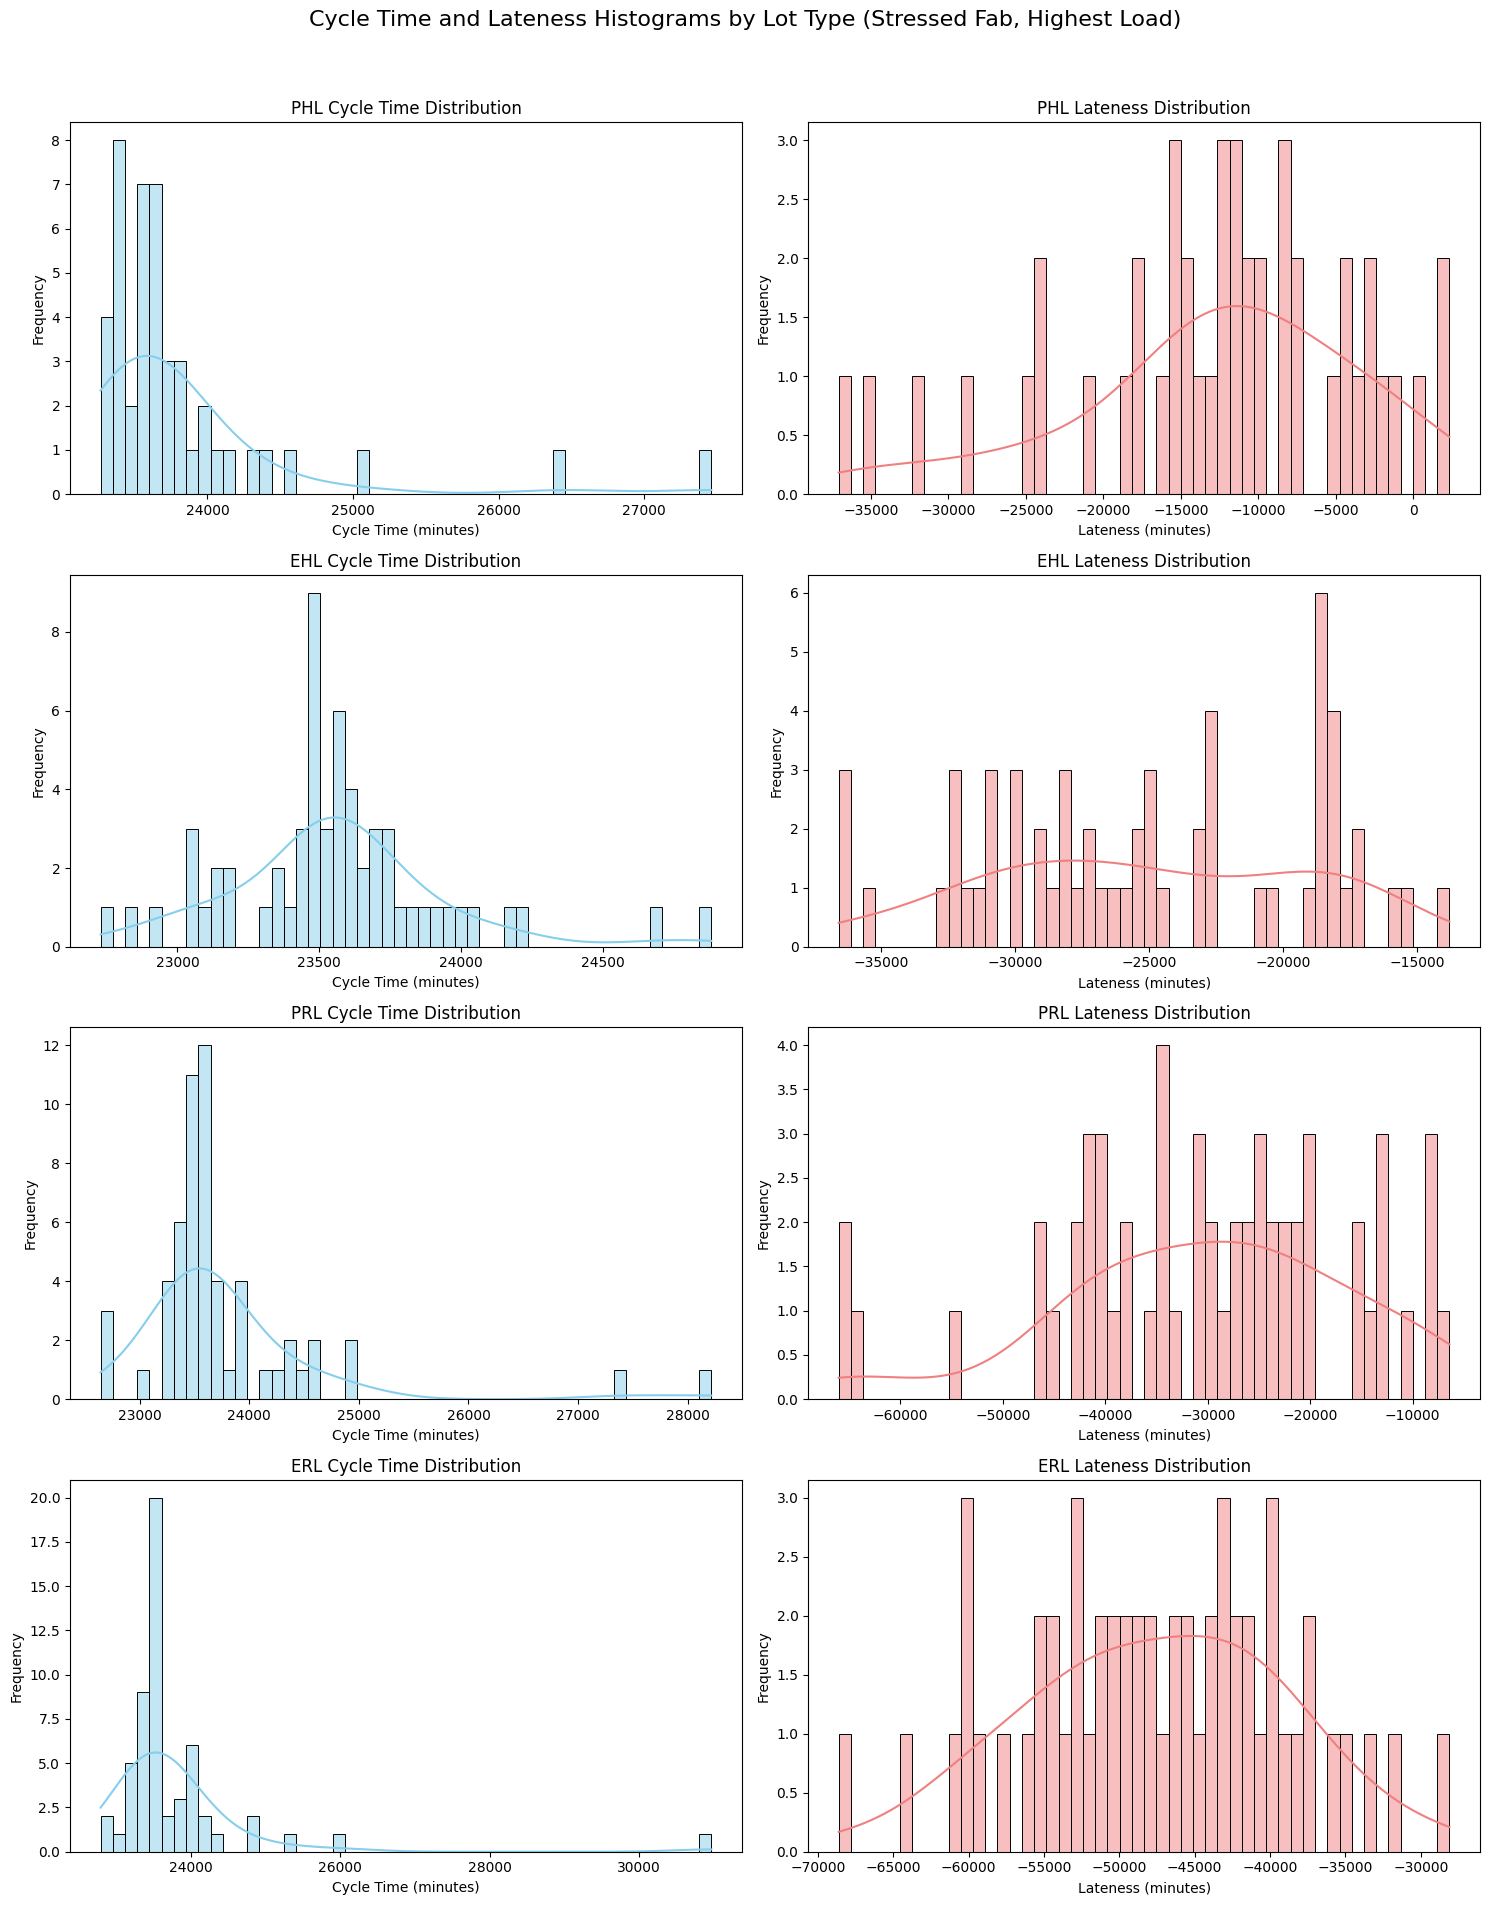


--- Summary of Operating Curve Data ---

Baseline Scenario:
   Loading_LotsPerType  AverageWIP  AverageCycleTime  TotalLotsCompleted
0                   10    0.256936      23552.503629                  12
1                   25    0.576653      23493.252895                  27
2                   50    1.215673      23460.360980                  57
3                   75    1.765628      23451.085948                  81
4                  100    2.215696      23476.598914                 102
5                  125    2.904346      23523.344844                 134
6                  150    3.480813      23517.031891                 161
7                  175    4.172872      23562.209297                 193
8                  200    4.707652      23580.112413                 217

Reduced Bottleneck Capacity Scenario:
   Loading_LotsPerType  AverageWIP  AverageCycleTime  TotalLotsCompleted
0                   10    0.256739      23534.445530                  12
1                   25  

In [2]:
import simpy
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading and Preprocessing ---
file_path = "SMT_2020_Model_Data_-_LVHM_E.xlsx"

# Load essential data
lot_df_raw = pd.read_excel(file_path, sheet_name="Lotrelease - variable due dates")
lot_df_eng_raw = pd.read_excel(file_path, sheet_name="Lotrelease - Engineering")
route_df = pd.read_excel(file_path, sheet_name='Route_Product_4')

# Combine and preprocess lot data
initial_lot_df = pd.concat([lot_df_raw, lot_df_eng_raw], ignore_index=True)
initial_lot_df['START DATE'] = pd.to_datetime(initial_lot_df['START DATE'])
initial_lot_df['DUE DATE'] = pd.to_datetime(initial_lot_df['DUE DATE'])
base_time = initial_lot_df['START DATE'].min()
initial_lot_df['ReleaseTimeMin'] = (initial_lot_df['START DATE'] - base_time).dt.total_seconds() / 60
initial_lot_df['DueTimeMin'] = (initial_lot_df['DUE DATE'] - base_time).dt.total_seconds() / 60

# Route steps - now including 'BATCH MAXIMUM'
steps = route_df[['STEP', 'TOOLGROUP', 'MEAN', 'BATCH MAXIMUM']].dropna(subset=['STEP', 'TOOLGROUP', 'MEAN'])
steps['MEAN'] = pd.to_numeric(steps['MEAN'], errors='coerce')
# Ensure 'BATCH MAXIMUM' is numeric, coercing errors to NaN
steps['BATCH MAXIMUM'] = pd.to_numeric(steps['BATCH MAXIMUM'], errors='coerce')

# NEW: Create a dictionary for tool capacities from Route_Product_4's 'BATCH MAXIMUM'
# This handles cases where 'BATCH MAXIMUM' might be NaN or different for the same tool group
# Use a default capacity for tools not listed or with NaN capacity
DEFAULT_TOOL_CAPACITY_FALLBACK = 2 # A reasonable fallback if no specific capacity is found

tool_capacities_from_data = {}
for toolgroup in steps['TOOLGROUP'].unique():
    # Filter for the current toolgroup and get non-null BATCH MAXIMUM values
    capacities = steps[steps['TOOLGROUP'] == toolgroup]['BATCH MAXIMUM'].dropna()
    if not capacities.empty:
        # Take the maximum capacity if a toolgroup has multiple entries (e.g., different steps on same tool)
        tool_capacities_from_data[toolgroup] = int(capacities.max())
    else:
        # If no specific capacity or all are NaN for this toolgroup, use the fallback
        tool_capacities_from_data[toolgroup] = DEFAULT_TOOL_CAPACITY_FALLBACK

# Ensure all toolgroups in 'steps' have an entry in the capacity map, even if using fallback
for toolgroup in steps['TOOLGROUP'].unique():
    if toolgroup not in tool_capacities_from_data:
        tool_capacities_from_data[toolgroup] = DEFAULT_TOOL_CAPACITY_FALLBACK


# Calculate the theoretical minimum processing time for a single lot
MIN_PROCESSING_TIME_PER_LOT = steps['MEAN'].sum()

# --- Global Constants and Configuration ---
SIM_TIME = 1100000 # Total simulation time
SETUP_TIME = 10     # Time for tool setup change
LOAD_UNLOAD_TIME = 5 # Fixed time for loading and unloading a lot at a tool
TRANSPORT_TIME_MIN = 5 # Minimum transport time between tool groups
TRANSPORT_TIME_MAX = 10 # Maximum transport time between tool groups

BOTTLENECK_TOOLS = ['ETCH_D', 'LITHO_', 'THIN_F'] # These are still identified as conceptual bottlenecks
BATCH_TOOLS = ['DIFF_'] # Example: Diffusion is a known batching area from paper

# --- Lot Classification ---
def classify_lot_type(lot_id):
    if pd.isna(lot_id): return "Unknown"
    lot_str = str(lot_id).upper()
    if "ENG" in lot_str:
        return "EHL" if "HL" in lot_str or "HOT" in lot_str else "ERL"
    elif "HL" in lot_str or "HOT" in lot_str:
        return "PHL"
    else:
        return "PRL"

def balanced_sample(df, n_each=100):
    sampled = []
    for t in ['PRL', 'PHL', 'ERL', 'EHL']:
        subset = df[df['LOT NAME/TYPE'].apply(classify_lot_type) == t]
        if not subset.empty:
            sampled.append(subset.sample(n=min(n_each, len(subset)), random_state=42))
    return pd.concat(sampled)

# --- WIP Tracking & Tool Monitoring Class ---
class SimStats:
    def __init__(self):
        self.current_wip = 0
        self.wip_history = [] # Stores (time, wip_count)
        self.tool_metrics_history = {} # Stores {tool_name: [(time, queue_len, in_use)]}

    def record_wip(self, env_time):
        self.wip_history.append((env_time, self.current_wip))

    def record_tool_stats(self, env_time, tool_name, queue_len, in_use_count):
        if tool_name not in self.tool_metrics_history:
            self.tool_metrics_history[tool_name] = []
        self.tool_metrics_history[tool_name].append((env_time, queue_len, in_use_count))

# --- Simulation Logic (Refactored to a function to enable multiple runs with config) ---
def run_cr_dispatch_sim_with_config(
    num_lots_per_type_sample,
    initial_lot_dataframe,
    tool_capacities_data, # Now explicitly passes tool capacities from data
    tool_downtime_configs,
    processing_time_type
):
    env = simpy.Environment()
    sim_stats = SimStats()
    
    lot_df_for_run = balanced_sample(initial_lot_dataframe, n_each=num_lots_per_type_sample)
    lot_df_for_run['LotType'] = lot_df_for_run['LOT NAME/TYPE'].apply(classify_lot_type)

    # Due dates are now directly from the preprocessed initial_lot_df
    # No need to override them here with fixed values
    # lot_df_for_run.loc[lot_df_for_run['LotType'].isin(['PHL', 'EHL']), 'DueTimeMin'] = \
    #     lot_df_for_run['ReleaseTimeMin'] + 30000
    # lot_df_for_run.loc[lot_df_for_run['LotType'].isin(['PRL', 'ERL']), 'DueTimeMin'] = \
    #     lot_df_for_run['ReleaseTimeMin'] + 70000

    tool_resources = {}
    tool_capacities_map = {} # To store actual capacities used in this run for bottleneck analysis

    for tool in steps['TOOLGROUP'].unique():
        # Get capacity from the provided tool_capacities_data, default to 1 if not found
        capacity = tool_capacities_data.get(tool, 1) # Fallback to 1 if a tool somehow isn't in the map

        tool_resources[tool] = simpy.PriorityResource(env, capacity=capacity)
        tool_capacities_map[tool] = capacity # Store capacity for later analysis

    last_operation = {tool: None for tool in steps['TOOLGROUP'].unique()}

    # --- Tool Downtime Behavior (Now tool-specific) ---
    def tool_downtime_behavior(env, tool_name, tool_resource, downtime_params):
        pm_interval = downtime_params.get('pm_interval')
        pm_duration = downtime_params.get('pm_duration')
        mtbf = downtime_params.get('mtbf')
        mttr = downtime_params.get('mttr')

        if not all([pm_interval, pm_duration, mtbf, mttr]):
            return # Skip downtime process if parameters are incomplete

        while True:
            # Scheduled Maintenance (PM)
            yield env.timeout(pm_interval)
            with tool_resource.request(priority=-1000) as req: # High priority to ensure PM happens
                yield req
                yield env.timeout(pm_duration)

            # Unscheduled Downtime (Breakdown)
            yield env.timeout(random.expovariate(1.0 / mtbf))
            with tool_resource.request(priority=-2000) as req: # Even higher priority for breakdowns
                yield req
                yield env.timeout(random.expovariate(1.0 / mttr))

    # Start tool-specific downtime processes
    for tool_name, resource in tool_resources.items():
        tool_params = tool_downtime_configs.get(tool_name)
        if tool_params: # Only start process if parameters are available
            env.process(tool_downtime_behavior(env, tool_name, resource, tool_params))

    lot_records = {} # To store results for each lot

    def process_lot(env, lot_id, release, due, lot_type, sim_stats_instance):
        yield env.timeout(max(0, release - env.now))

        sim_stats_instance.current_wip += 1
        sim_stats_instance.record_wip(env.now)

        lot_records[lot_id] = {
            'start': env.now,
            'due': due,
            'type': lot_type,
            'release': release
        }

        min_processing_time = MIN_PROCESSING_TIME_PER_LOT
        lot_records[lot_id]['min_processing_time'] = min_processing_time

        for idx, row in steps.iterrows():
            tool = row['TOOLGROUP']

            if idx > 0:
                yield env.timeout(random.uniform(TRANSPORT_TIME_MIN, TRANSPORT_TIME_MAX))

            if processing_time_type == 'deterministic':
                proc_time = row['MEAN']
            else: # 'variable'
                proc_time = random.uniform(row['MEAN'] * 0.95, row['MEAN'] * 1.05)
                proc_time = max(1, proc_time) # Ensure processing time is at least 1 min

            proc_time += LOAD_UNLOAD_TIME

            remaining_proc_time = steps.loc[idx:, 'MEAN'].sum()
            time_until_due = max(due - env.now, 0.01)

            cr = remaining_proc_time / time_until_due

            if lot_type in ['PHL', 'EHL']:
                cr *= 0.25

            priority = cr

            with tool_resources[tool].request(priority=priority) as req:
                yield req

                if last_operation[tool] != row['STEP']:
                    yield env.timeout(SETUP_TIME)
                    last_operation[tool] = row['STEP']

                yield env.timeout(proc_time)

        lot_records[lot_id]['end'] = env.now
        sim_stats_instance.current_wip -= 1
        sim_stats_instance.record_wip(env.now)

    def lot_release(env, lots_to_release_df, sim_stats_instance):
        for _, row in lots_to_release_df.iterrows():
            lot_id = row['LOT NAME/TYPE']
            release = row['ReleaseTimeMin']
            due = row['DueTimeMin'] # Directly use the preprocessed DueTimeMin
            lot_type = classify_lot_type(lot_id)
            env.process(process_lot(env, lot_id, release, due, lot_type, sim_stats_instance))
            yield env.timeout(0)

    def wip_monitor(env, sim_stats_instance, interval=1000):
        while True:
            sim_stats_instance.record_wip(env.now)
            yield env.timeout(interval)

    def tool_stats_monitor(env, tool_resources, sim_stats_instance, interval=1000):
        while True:
            for tool_name, resource in tool_resources.items():
                sim_stats_instance.record_tool_stats(
                    env.now, tool_name, len(resource.queue), resource.count
                )
            yield env.timeout(interval)

    env.process(lot_release(env, lot_df_for_run, sim_stats))
    env.process(wip_monitor(env, sim_stats))
    env.process(tool_stats_monitor(env, tool_resources, sim_stats))
    env.run(until=SIM_TIME)

    rows = []
    for lot_id, rec in lot_records.items():
        if 'end' in rec:
            start = rec['start']
            end = rec['end']
            due = rec['due']
            release = rec['release']

            cycle = end - start
            lateness = end - due
            min_processing_time = rec['min_processing_time']
            target_cycle_time = due - release

            rows.append({
                'Lot': lot_id,
                'Type': rec['type'],
                'Start': start,
                'End': end,
                'Due': due,
                'CycleTime': cycle,
                'MinProcessingTime': min_processing_time,
                'TargetCycleTime': target_cycle_time,
                'Lateness': lateness,
                'OnTime': end <= due
            })

    df_results = pd.DataFrame(rows)
    return df_results, sim_stats.wip_history, sim_stats.tool_metrics_history, tool_capacities_map

def calculate_time_weighted_average_wip(wip_history, sim_end_time):
    if not wip_history:
        return 0

    total_area = 0
    last_time = 0
    last_wip = 0

    filtered_history = [item for item in wip_history if item[0] >= 0]
    if not filtered_history:
        return 0

    if filtered_history[0][0] != 0:
        filtered_history.insert(0, (0, 0))

    for time, wip in filtered_history:
        if time > last_time:
            total_area += last_wip * (time - last_time)
        last_time = time
        last_wip = wip

    total_area += last_wip * (sim_end_time - last_time)

    if sim_end_time > 0:
        return total_area / sim_end_time
    return 0

# --- Bottleneck Analysis Function ---
def analyze_bottlenecks(tool_metrics_history, sim_end_time, tool_capacities_map):
    tool_metrics = {}
    for tool_name, history in tool_metrics_history.items():
        if history and history[-1][0] < sim_end_time:
            history.append((sim_end_time, history[-1][1], history[-1][2]))

        total_queue_len_area = 0
        total_in_use_area = 0
        last_time = 0
        last_queue_len = 0
        last_in_use_count = 0

        processed_history = sorted(history, key=lambda x: x[0])
        if not processed_history or processed_history[0][0] != 0:
            processed_history.insert(0, (0, 0, 0))

        for time, queue_len, in_use_count in processed_history:
            time_diff = time - last_time
            if time_diff > 0:
                total_queue_len_area += last_queue_len * time_diff
                total_in_use_area += last_in_use_count * time_diff

            last_time = time
            last_queue_len = queue_len
            last_in_use_count = in_use_count
            
        avg_queue_len = total_queue_len_area / sim_end_time if sim_end_time > 0 else 0
        
        capacity = tool_capacities_map.get(tool_name, 1)
        avg_in_use = total_in_use_area / sim_end_time if sim_end_time > 0 else 0
        
        utilization = (avg_in_use / capacity) * 100 if capacity > 0 else 0

        tool_metrics[tool_name] = {
            'AvgQueueLength': avg_queue_len,
            'AvgUtilization': utilization,
            'Capacity': capacity
        }
    return pd.DataFrame.from_dict(tool_metrics, orient='index')


def generate_operating_curve_data(scenario_name, config):
    print(f"\n--- Generating Operating Curve for Scenario: {scenario_name} ---")
    operating_curve_data = []
    last_tool_metrics_history = None
    last_tool_capacities_map = None
    
    loading_levels = [10, 25, 50, 75, 100, 125, 150, 175, 200]
    
    df_highest_load_results = pd.DataFrame()
    tool_metrics_history_highest_load = {}

    for num_lots_per_type in loading_levels:
        print(f"  Running simulation with {num_lots_per_type} lots per type...")
        df_current_run_results, wip_history_current_run, tool_metrics_history_current_run, tool_capacities_map_current_run = run_cr_dispatch_sim_with_config(
            num_lots_per_type,
            initial_lot_df,
            config['tool_capacities'], # Pass the tool capacities from the config
            config['tool_downtime_configs'],
            config['processing_time_type']
        )
        
        if num_lots_per_type == loading_levels[-1]:
            last_tool_metrics_history = tool_metrics_history_current_run
            last_tool_capacities_map = tool_capacities_map_current_run
            df_highest_load_results = df_current_run_results
            tool_metrics_history_highest_load = tool_metrics_history_current_run


        if not df_current_run_results.empty:
            avg_cycle_time = df_current_run_results['CycleTime'].mean()
            avg_wip = calculate_time_weighted_average_wip(wip_history_current_run, SIM_TIME)
            
            operating_curve_data.append({
                'Loading_LotsPerType': num_lots_per_type,
                'AverageWIP': avg_wip,
                'AverageCycleTime': avg_cycle_time,
                'TotalLotsCompleted': len(df_current_run_results)
            })
            print(f"  Completed {len(df_current_run_results)} lots. Avg WIP: {avg_wip:.2f}, Avg Cycle Time: {avg_cycle_time:.2f}")
        else:
            print("  No lots completed in this run. Skipping.")
    
    return pd.DataFrame(operating_curve_data), last_tool_metrics_history, last_tool_capacities_map, df_highest_load_results, tool_metrics_history_highest_load

# --- Plotting Functions for Enhanced Visualization ---

def plot_top_n_tool_queue_lengths(tool_metrics_history, top_n_bottlenecks_df, n=10, title_suffix=""):
    """
    Plots the queue length over time for the top N bottleneck tools.
    """
    if top_n_bottlenecks_df.empty or not tool_metrics_history:
        print("No bottleneck data or tool metrics history available for plotting queue lengths.")
        return

    # Get the names of the top N bottleneck tools
    top_n_tool_names = top_n_bottlenecks_df.index.tolist()[:n]
    
    if not top_n_tool_names:
        print("No top bottleneck tools identified for plotting.")
        return

    # Determine optimal grid size for subplots
    num_plots = len(top_n_tool_names)
    cols = min(4, num_plots)
    rows = (num_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True)
    axes = axes.flatten() if rows > 1 or cols > 1 else [axes] # Handle single subplot case

    for i, tool_name in enumerate(top_n_tool_names):
        if tool_name in tool_metrics_history and tool_metrics_history[tool_name]:
            times = [item[0] for item in tool_metrics_history[tool_name]]
            queue_lengths = [item[1] for item in tool_metrics_history[tool_name]]
            
            axes[i].plot(times, queue_lengths)
            axes[i].set_title(f"Queue Length: {tool_name}")
            axes[i].set_xlabel("Time (minutes)")
            axes[i].set_ylabel("Queue Length")
            axes[i].grid(True)
        else:
            # Hide empty subplot if data is missing for a tool
            fig.delaxes(axes[i])

    # Hide any remaining unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Queue Lengths for Top {n} Bottleneck Tools {title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


def plot_cycle_time_and_lateness_histograms(df_results, title_suffix=""):
    """
    Plots histograms of cycle times and lateness, broken down by lot type.
    """
    if df_results.empty:
        print("No results available for cycle time and lateness histograms.")
        return

    lot_types = df_results['Type'].unique()
    num_types = len(lot_types)

    fig, axes = plt.subplots(num_types, 2, figsize=(15, 5 * num_types))
    if num_types == 1: # Handle case with only one lot type
        axes = [axes] # Make it iterable

    for i, lot_type in enumerate(lot_types):
        subset = df_results[df_results['Type'] == lot_type]
        
        # Cycle Time Histogram
        sns.histplot(subset['CycleTime'], bins=50, kde=True, ax=axes[i][0], color='skyblue')
        axes[i][0].set_title(f'{lot_type} Cycle Time Distribution')
        axes[i][0].set_xlabel('Cycle Time (minutes)')
        axes[i][0].set_ylabel('Frequency')
        
        # Lateness Histogram
        sns.histplot(subset['Lateness'], bins=50, kde=True, ax=axes[i][1], color='lightcoral')
        axes[i][1].set_title(f'{lot_type} Lateness Distribution')
        axes[i][1].set_xlabel('Lateness (minutes)')
        axes[i][1].set_ylabel('Frequency')

    plt.suptitle(f"Cycle Time and Lateness Histograms by Lot Type {title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


# --- Scenario Configurations ---

# Define default downtime parameters for tools not specifically listed
DEFAULT_TOOL_PM_INTERVAL = 60000
DEFAULT_TOOL_PM_DURATION = 500
DEFAULT_TOOL_MTBF = 90000
DEFAULT_TOOL_MTTR = 3000

# Function to generate downtime config for all tools based on default or specific overrides
def generate_downtime_configs(base_pm_interval, base_pm_duration, base_mtbf, base_mttr, specific_overrides={}):
    all_tool_downtime_configs = {}
    for tool_name in steps['TOOLGROUP'].unique():
        all_tool_downtime_configs[tool_name] = {
            'pm_interval': base_pm_interval,
            'pm_duration': base_pm_duration,
            'mtbf': base_mtbf,
            'mttr': base_mttr
        }
    # Apply specific overrides
    for tool, params in specific_overrides.items():
        if tool in all_tool_downtime_configs: # Ensure the tool exists in our known tool groups
            all_tool_downtime_configs[tool].update(params)
    return all_tool_downtime_configs


# Scenario 1: Baseline (Using capacities from data, standard downtime)
config_baseline = {
    'tool_capacities': tool_capacities_from_data, # Use capacities from Route_Product_4
    'tool_downtime_configs': generate_downtime_configs(
        DEFAULT_TOOL_PM_INTERVAL, DEFAULT_TOOL_PM_DURATION,
        DEFAULT_TOOL_MTBF, DEFAULT_TOOL_MTTR
    ),
    'processing_time_type': 'deterministic'
}

# Scenario 2: Reduced Bottleneck Capacity (Override capacities for specific tools)
# This demonstrates how to vary capacities from data-driven defaults if needed for a scenario
reduced_capacity_overrides = tool_capacities_from_data.copy()
for tool in BOTTLENECK_TOOLS:
    # Set bottleneck tools to capacity 1, even if data says otherwise
    if tool in reduced_capacity_overrides:
        reduced_capacity_overrides[tool] = 1

config_reduced_capacity = {
    'tool_capacities': reduced_capacity_overrides,
    'tool_downtime_configs': generate_downtime_configs(
        DEFAULT_TOOL_PM_INTERVAL, DEFAULT_TOOL_PM_DURATION,
        DEFAULT_TOOL_MTBF, DEFAULT_TOOL_MTTR
    ),
    'processing_time_type': 'deterministic'
}

# Scenario 3: Stressed Fab (Reduced Bottleneck + Variable Proc. + Increased Downtime)
stressed_downtime_overrides = {
    'ETCH_D': {'pm_interval': 25000, 'pm_duration': 1000, 'mtbf': 40000, 'mttr': 5000},
    'LITHO_': {'pm_interval': 28000, 'pm_duration': 900, 'mtbf': 42000, 'mttr': 4800},
    'THIN_F': {'pm_interval': 22000, 'pm_duration': 1200, 'mtbf': 38000, 'mttr': 5500},
}
config_stressed_fab = {
    'tool_capacities': reduced_capacity_overrides, # Apply reduced bottleneck capacity here as well
    'tool_downtime_configs': generate_downtime_configs(
        base_pm_interval=30000, base_pm_duration=750, # General stressed downtime
        base_mtbf=45000, base_mttr=4500,
        specific_overrides=stressed_downtime_overrides # Specific overrides for bottlenecks
    ),
    'processing_time_type': 'variable'
}


# --- Run Simulations for Each Scenario ---
# The return values for generate_operating_curve_data now include df_highest_load_results
# and tool_metrics_history_highest_load for direct plotting.
df_operating_curve_baseline, _, _, _, _ = generate_operating_curve_data("Baseline", config_baseline)
df_operating_curve_reduced, _, _, _, _ = generate_operating_curve_data("Reduced Bottleneck Capacity", config_reduced_capacity)
df_operating_curve_stressed, stressed_tool_metrics_history_highest_load_level, stressed_tool_capacities_map_highest_load_level, df_stressed_fab_results_highest_load_level, tool_metrics_history_for_plotting = generate_operating_curve_data("Stressed Fab", config_stressed_fab)


# --- Plotting All Operating Curves on One Graph ---
plt.figure(figsize=(12, 7))

if not df_operating_curve_baseline.empty:
    sns.lineplot(data=df_operating_curve_baseline, x='AverageWIP', y='AverageCycleTime', marker='o', color='blue', label='Baseline')
if not df_operating_curve_reduced.empty:
    sns.lineplot(data=df_operating_curve_reduced, x='AverageWIP', y='AverageCycleTime', marker='o', color='red', label='Reduced Bottleneck Capacity')
if not df_operating_curve_stressed.empty:
    sns.lineplot(data=df_operating_curve_stressed, x='AverageWIP', y='AverageCycleTime', marker='o', color='purple', label='Stressed Fab')

plt.title("Comparison of Operating Curves: WIP vs. Cycle Time")
plt.xlabel("Average Work-In-Process (WIP)")
plt.ylabel("Average Cycle Time (minutes)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Bottleneck Analysis for the Stressed Fab at Highest Load ---
if stressed_tool_metrics_history_highest_load_level and stressed_tool_capacities_map_highest_load_level:
    print("\n--- Bottleneck Analysis for Stressed Fab (Highest Load) ---")
    df_bottleneck_stressed = analyze_bottlenecks(stressed_tool_metrics_history_highest_load_level, SIM_TIME, stressed_tool_capacities_map_highest_load_level)
    # Sort by AvgQueueLength and then AvgUtilization to identify the most congested tools
    # PRINT ONLY TOP 10
    print(df_bottleneck_stressed.sort_values(by=['AvgQueueLength', 'AvgUtilization'], ascending=False).head(10))
else:
    print("\n--- Bottleneck analysis data not available for Stressed Fab. ---")

# --- Generate Enhanced Plots for the Stressed Fab at Highest Load ---
if not df_stressed_fab_results_highest_load_level.empty:
    print("\n--- Generating Detailed Plots for Stressed Fab (Highest Load) ---")
    
    # Sort bottlenecks to get the top N for plotting
    if stressed_tool_metrics_history_highest_load_level and stressed_tool_capacities_map_highest_load_level:
        df_bottleneck_stressed_sorted_for_plot = analyze_bottlenecks(stressed_tool_metrics_history_highest_load_level, SIM_TIME, stressed_tool_capacities_map_highest_load_level)
        df_bottleneck_stressed_sorted_for_plot = df_bottleneck_stressed_sorted_for_plot.sort_values(by=['AvgQueueLength', 'AvgUtilization'], ascending=False)
        plot_top_n_tool_queue_lengths(tool_metrics_history_for_plotting, df_bottleneck_stressed_sorted_for_plot, n=10, title_suffix="(Stressed Fab, Highest Load)")
    else:
        print("Cannot plot top 10 bottleneck tool queue lengths due to missing data.")

    plot_cycle_time_and_lateness_histograms(df_stressed_fab_results_highest_load_level, title_suffix="(Stressed Fab, Highest Load)")
else:
    print("\n--- No completed lots for detailed plotting in Stressed Fab at highest load. ---")

print("\n--- Summary of Operating Curve Data ---")
print("\nBaseline Scenario:")
print(df_operating_curve_baseline)
print("\nReduced Bottleneck Capacity Scenario:")
print(df_operating_curve_reduced)
print("\nStressed Fab Scenario:")
print(df_operating_curve_stressed)